In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle as pkl

import scipy as sp
from scipy.sparse.csgraph import minimum_spanning_tree

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import community as community_louvain
from wordcloud import WordCloud
import math
#import netrd
from scipy.linalg import svd
#from grakel.kernels import WeisfeilerLehman, VertexHistogram
#from grakel.utils import graph_from_networkx

## Create Directed Trade Networks of Aggregated Import Value

In [2]:
temp = pd.read_stata("data/country_partner_sitcproductsection_year.dta")

In [3]:
#SITC revision 2 product code definitions
data_dict = pd.read_json('https://comtrade.un.org/data/cache/classificationS2.json')

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>

In [ ]:
data_cross = []
i = 0
for item_def in list(data_dict["results"]):
    if(i >= 2):
        data_cross.append(item_def["text"].split(" - ", 1))
    i = i+1

product_codes = pd.DataFrame(data_cross, columns = ['code', 'product'])

In [4]:
country_codes = pd.read_excel("data/ISO3166.xlsx")

#rename some columns for join with trade data
country_codes["location_code"] = country_codes["Alpha-3 code"]
country_codes["partner_code"] = country_codes["Alpha-3 code"]
country_codes["country_i"] = country_codes["English short name"]
country_codes["country_j"] = country_codes["English short name"]
#product_codes["sitc_product_code"] = product_codes["code"]

In [13]:
def clean_imports(df):
    #join trade data and descriptions
    df = pd.merge(df, country_codes[["location_code", "country_i"]],on = ["location_code"])
    df = pd.merge(df, country_codes[["partner_code", "country_j"]],on = ["partner_code"])
    #df = pd.merge(df, product_codes[["sitc_product_code", "product"]], on = ["sitc_product_code"])

    imports1 = df[['location_id', 'partner_id', 'product_id', 'year',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j']]
    imports1 = imports1[imports1["import_value"] != 0]

    imports2 = df[['location_id', 'partner_id', 'product_id', 'year',
       'export_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j']]
    imports2["temp1"] = imports2['partner_code']
    imports2["temp2"] = imports2['location_code']

    imports2['location_code'] = imports2["temp1"]
    imports2['partner_code'] = imports2["temp2"]
    imports2["import_value"] = imports2["export_value"]
    imports2 = imports2[imports2["import_value"] != 0]
    imports2 = imports1[['location_id', 'partner_id', 'product_id', 'year',
        'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
        'sitc_product_code', 'country_i', 'country_j']]
    
    imports = pd.concat([imports1, imports2], ignore_index=True)
    
    return imports

In [14]:
def clean_exports(df):
    #join trade data and descriptions
    df = pd.merge(df, country_codes[["location_code", "country_i"]],on = ["location_code"])
    df = pd.merge(df, country_codes[["partner_code", "country_j"]],on = ["partner_code"])
    #df = pd.merge(df, product_codes[["sitc_product_code", "product"]], on = ["sitc_product_code"])

    exports1 = df[['location_id', 'partner_id', 'product_id', 'year',
       'export_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j']]
    exports1 = exports1[exports1["export_value"] != 0]

    exports2 = df[['location_id', 'partner_id', 'product_id', 'year',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j']]
    exports2["temp1"] = exports2['partner_code']
    exports2["temp2"] = exports2['location_code']

    exports2['location_code'] = exports2["temp1"]
    exports2['partner_code'] = exports2["temp2"]
    exports2["export_value"] = exports2["import_value"]
    exports2 = exports2[exports2["export_value"] != 0]
    exports2 = exports1[['location_id', 'partner_id', 'product_id', 'year',
        'export_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
        'sitc_product_code', 'country_i', 'country_j']]
    
    exports = pd.concat([exports1, exports2], ignore_index=True)
    
    return exports

In [5]:
locations = pd.read_stata("location_classifications/location.dta")
locations['location_id'] = locations['location_id'].astype(int)
locations.drop(columns = ['location_id','location_name_short_en','level'], inplace = True)

In [10]:
#import trade data
export_data = []
for i in range(1962,2022):
    file_name = (f"data/country_partner_sitcproduct4digit_year_{i}.dta")
    year_data = pd.read_stata(file_name)
    trade = clean_exports(year_data)
    
    trade = trade.merge(locations, left_on = "partner_code", right_on = "location_code")
    trade.rename(columns = {"location_code_x":"location_code"}, inplace = True)
    trade.drop(columns = ["location_code_y"], inplace = True)

    export_data.append(trade)

In [11]:
#import trade data
import_data = []
for i in range(1962,2022):
    file_name = (f"data/country_partner_sitcproduct4digit_year_{i}.dta")
    year_data = pd.read_stata(file_name)
    trade = clean_imports(year_data)
    
    trade = trade.merge(locations, left_on = "partner_code", right_on = "location_code")
    trade.rename(columns = {"location_code_x":"location_code"}, inplace = True)
    trade.drop(columns = ["location_code_y"], inplace = True)

    import_data.append(trade)

In [12]:
#Group dataframe by country
import_agg = []
for i in import_data:
    import_agg.append(i.groupby(["location_code","partner_code"])['import_value'].sum().reset_index())

In [27]:
with open('imports_agg.pkl', 'wb') as file:
    pkl.dump(import_agg, file)

In [13]:
#Group dataframe by country
export_agg = []
for i in export_data:
    export_agg.append(i.groupby(["location_code","partner_code"])['export_value'].sum().reset_index())

In [28]:
with open('exports_agg.pkl', 'wb') as file:
    pkl.dump(export_agg, file)

## Standardizing Node Length of Aggregated Dataframes

In [14]:
export_partners = []
for i in export_agg:
    df = i.pivot(index='location_code', columns='partner_code', values='export_value')
    df = df.fillna(0)
    export_partners.append(df)

In [15]:
import_partners = []
for i in import_agg:
    df = i.pivot(index='location_code', columns='partner_code', values='import_value')
    df = df.fillna(0)
    import_partners.append(df)

In [16]:
import_percent = []
for i in import_partners:
    df = i.div(i.sum(axis=1), axis=0)
    import_percent.append(df)

In [17]:
export_percent = []
for i in export_partners:
    df = i.div(i.sum(axis=1), axis=0)
    export_percent.append(df)

In [18]:
max_index = []
max_len = len(export_percent[0].index)
for i in export_percent:
    if len(i.index) > max_len:
        max_index = i.index

In [19]:
for i in export_percent:
    for j in max_index:
        if j not in i.columns:
            i[j] = 0
        if j not in i.index:
            i.loc[j] = 0

In [20]:
max_columns = export_percent[0].columns
max_len = len(export_percent[0].columns)
for i in export_percent:
    if len(i.columns) > max_len:
        max_columns = i.columns

In [21]:
for i in export_percent:
    for j in max_columns:
        if j not in i.columns:
            i[j] = 0
        if j not in i.index:
            i.loc[j] = 0

In [57]:
for i in export_percent:
    if len(i) != 240:
        missing_cols = export_percent[38].columns.difference(i.columns)
        for j in missing_cols:
            i[j] = 0
            i.loc[j] = 0

In [69]:
for i in export_percent:
    if len(i.index)!= 240:
        missing_index = export_percent[38].index.difference(i.index)
        for j in missing_index:
            i.loc[j] = 0

In [22]:
max_index = []
max_len = len(import_percent[0].index)
for i in import_percent:
    if len(i.index) > max_len:
        max_index = i.index

In [23]:
for i in import_percent:
    for j in max_index:
        if j not in i.columns:
            i[j] = 0
        if j not in i.index:
            i.loc[j] = 0

In [24]:
max_columns = import_percent[0].columns
max_len = len(import_percent[0].columns)
for i in import_percent:
    if len(i.columns) > max_len:
        max_columns = i.columns

In [25]:
for i in import_percent:
    for j in max_columns:
        if j not in i.columns:
            i[j] = 0
        if j not in i.index:
            i.loc[j] = 0

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_50100/2263629442.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  i[j] = 0


In [52]:
for i in import_percent:
    if len(i) != 240:
        missing_cols = import_percent[38].columns.difference(i.columns)
        for j in missing_cols:
            i[j] = 0
            i.loc[j] = 0

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_50100/944248445.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  i[j] = 0


In [ ]:
for i in import_percent:
    if len(i.index) != 240:
        missing_index = import_percent[38].columns.difference(i.columns)
        for j in missing_cols:
            i[j] = 0
            i.loc[j] = 0

In [72]:
export_graphs = []

for y in export_percent:
    G = nx.from_pandas_adjacency(y, create_using=nx.DiGraph())
    export_graphs.append(G)

In [73]:
import_graphs = []

for y in import_percent:
    G = nx.from_pandas_adjacency(y, create_using=nx.DiGraph())
    import_graphs.append(G)

In [75]:
with open('export_graphs.pkl', 'wb') as file:
    pkl.dump(export_graphs, file)

In [74]:
with open('import_graphs.pkl', 'wb') as file:
    pkl.dump(import_graphs, file)

## Traditional Change-Point Distances

In [6]:
def frobenius_distance(G1, G2):
    """
    Computes Frobenius distance between two graphs using the Frobenius norm.

    Parameters   
    G1, G2 (nx.Graph) : Graphs to compare
    Returns
    frobenius_distance (float) : frobenius distance between the two graphs
    """
    # Assuming 'G1' and 'G2' are your graphs
    w1 = nx.adjacency_matrix(G1.to_undirected()).toarray()
    w2 = nx.adjacency_matrix(G2.to_undirected()).toarray()

    w_diff = w1 - w2
    frobenius_distance = np.linalg.norm(w_diff, 'fro')
    return frobenius_distance

In [7]:
def procrustes_distance(G1, G2):
    """
    Computes Procrustes distance between two graphs using the Frobenius norm for the symmetric Laplacian matrix.

    Parameters   
    G1, G2 (nx.Graph) : Graphs to compare
    Returns
    procrustes_distance (float) : Procrustes distance between the two graphs
    """

    # Assuming 'G1' and 'G2' are your graphs
    A1 = nx.adjacency_matrix(G1).toarray()
    A2 = nx.adjacency_matrix(G2).toarray()

    # Perform SVD on the adjacency matrices
    U1, _, _ = svd(A1)
    U2, _, _ = svd(A2)

    # Compute the Procrustes distance
    procrustes_distance = np.linalg.norm(U1 - U2, 'fro')

    return procrustes_distance

In [8]:
def jaccard_distance(G1, G2):
    # Convert the graphs to edge sets
    edge_set1 = set(G1.edges())
    edge_set2 = set(G2.edges())

    # Compute the intersection and union of the edge sets
    intersection = edge_set1 & edge_set2
    union = edge_set1 | edge_set2

    # Compute the Jaccard coefficient
    jaccard_coefficient = len(intersection) / len(union)

    # Compute the Jaccard distance
    jaccard_distance = 1 - jaccard_coefficient

    return jaccard_distance

In [9]:
def pairwise_distance(graphs, dist_type):
    """
    Create pairwise matrix which contains the distance for every pair of graphs

    #Parameters
    graphs - list of graphs
    dist_type - specified distance function
    """
    i = len(graphs)
    distances = np.zeros(shape=(i,i))
    for i in range(len(graphs)):
        for j in range(len(graphs)):
            distances[i][j] = dist_type(graphs[i], graphs[j])
    return distances

In [101]:
frobenius_distances = pairwise_distance(export_graphs, frobenius_distance)

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_50100/4165842377.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  L1 = nx.adjacency_matrix(G1.to_undirected()).toarray()
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_50100/4165842377.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  L2 = nx.adjacency_matrix(G2.to_undirected()).toarray()


In [144]:
frobenius_distances_imports = pairwise_distance(import_graphs, frobenius_distance)

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_50100/529599282.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  w1 = nx.adjacency_matrix(G1.to_undirected()).toarray()
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_50100/529599282.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  w2 = nx.adjacency_matrix(G2.to_undirected()).toarray()


In [140]:
procrustes_distances = pairwise_distance(export_graphs, procrustes_distance)

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_50100/3745436887.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.adjacency_matrix(G1).toarray()
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_50100/3745436887.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.adjacency_matrix(G2).toarray()


In [159]:
procrustes_distances_imports = pairwise_distance(import_graphs, procrustes_distance)

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_50100/3745436887.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.adjacency_matrix(G1).toarray()
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_50100/3745436887.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.adjacency_matrix(G2).toarray()


In [162]:
jaccard_distances_imports = pairwise_distance(import_graphs, jaccard_distance)
jaccard_distances_exports = pairwise_distance(export_graphs, jaccard_distance)

In [121]:
with open('frobenius_distance_exports.pkl', 'wb') as file:
    pkl.dump(frobenius_distances, file)

In [142]:
with open('procrustes_distance_exports.pkl', 'wb') as file:
    pkl.dump(procrustes_distances, file)

In [157]:
def create_heatmaps(import_distances, export_distances, distance_name):
    # Create subplots
    years = range(1962,2022)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    xlabels = [i if i % 5 == 0 else '' for i in years]  # change the step to your preference
    ylabels = [i if i % 5 == 0 else '' for i in years]  # change the step to your preference
    sns.heatmap(import_distances, ax=axs[0], cmap='YlGnBu', cbar=True, xticklabels=xlabels, yticklabels=ylabels)

    axs[0].set_xticklabels(xlabels, size='small')
    axs[0].set_yticklabels(ylabels, size='small')
    axs[0].set_title(f"{distance_name} for Imports")

    sns.heatmap(export_distances, ax=axs[1], cmap='YlGnBu', cbar=True, xticklabels=xlabels, yticklabels=ylabels)

    axs[1].set_xticklabels(xlabels, size='small')
    axs[1].set_yticklabels(ylabels, size='small')
    axs[1].set_title(f"{distance_name} for Exports")

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

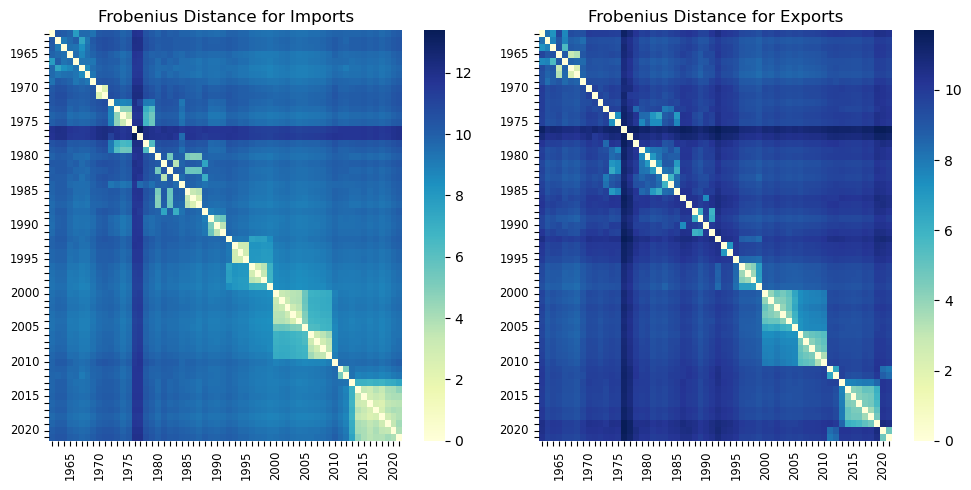

In [158]:
create_heatmaps(frobenius_distances_imports, frobenius_distances, 'Frobenius Distance')

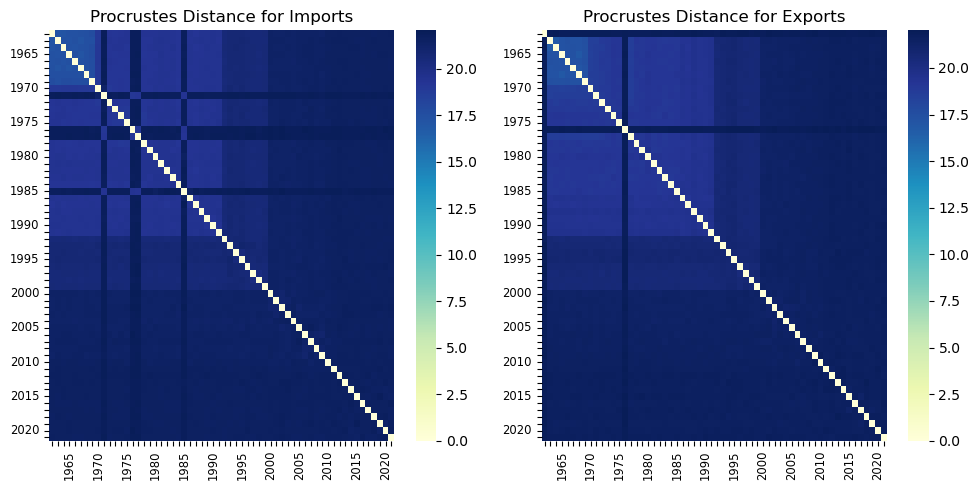

In [160]:
create_heatmaps(procrustes_distances_imports, procrustes_distances, 'Procrustes Distance')

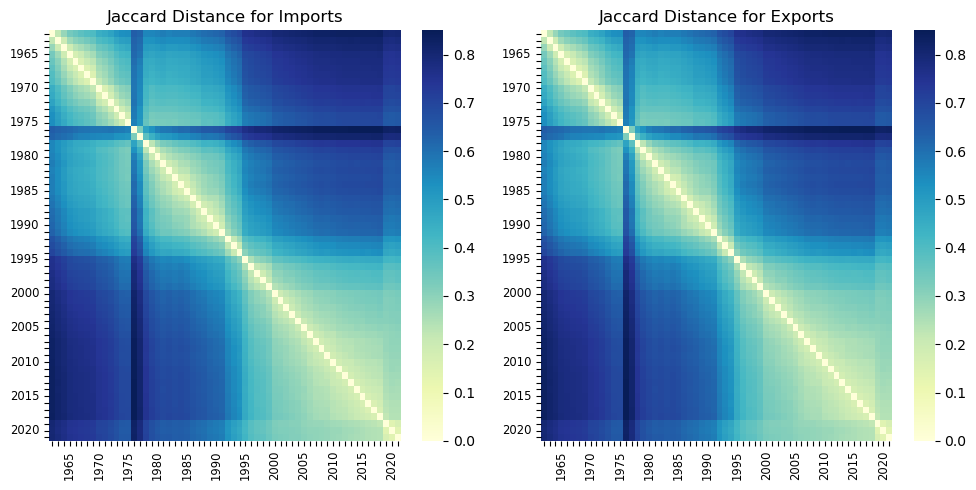

In [163]:
create_heatmaps(jaccard_distances_imports, jaccard_distances_exports, 'Jaccard Distance')

## Distances by Region

In [50]:
regions = locations['parent_id'].unique()
regions = regions[np.logical_and(~np.isnan(regions), regions != 358)]

### Exports

In [66]:
with open('graphs/exports_agg.pkl', 'rb') as file:
    exports_agg = pkl.load(file)

In [67]:
regions_data_exports = []
for r in regions:
    trade_by_year = []
    for i in exports_agg:
        trade = i.merge(locations, left_on = "location_code", right_on = "location_code")
        trade.rename(columns = {"location_code_x":"location_code"}, inplace = True)
        trade_by_year.append(trade[trade['parent_id'] == r])
    regions_data_exports.append(trade_by_year)

In [68]:
regions_pivot_exports = []
for r in regions_data_exports:
    export_partners_region = []
    for i in r:
        df = i.pivot(index='location_code', columns='partner_code', values='export_value')
        df = df.fillna(0)
        export_partners_region.append(df)
    regions_pivot_exports.append(export_partners_region)

In [69]:
region_percents_exports = []
for r in regions_pivot_exports:
    export_percent = []
    for i in r:
        df = i.div(i.sum(axis=1), axis=0)
        export_percent.append(df)

    region_percents_exports.append(export_percent)

In [70]:
for r in region_percents_exports: 

    max_index = []
    max_len = len(r[0].index)
    for i in r:
        if len(i.index) > max_len:
            max_index = i.index

    for i in r:
        for j in max_index:
            if j not in i.columns:
                i[j] = 0
            if j not in i.index:
                i.loc[j] = 0

In [71]:
exports_graphs_regions = []

for r in region_percents_exports:
    export_graphs = []
    for y in r:
        G = nx.from_pandas_adjacency(y, create_using=nx.DiGraph())
        export_graphs.append(G)
    exports_graphs_regions.append(export_graphs)

NetworkXError: ('Columns must match Indices.', "['MTQ'] not in columns")

In [ ]:
with open('region_graphs_exports.pkl', 'wb') as file:
    pkl.dump(exports_graphs_regions, file)

In [ ]:
jaccard_regions_exports = []
for i in exports_graphs_regions:
    jaccard_regions_exports.append(pairwise_distance(i, jaccard_distance))

In [62]:
frobenius_regions_exports = []
for i in exports_graphs_regions:
    frobenius_regions_exports.append(pairwise_distance(i, frobenius_distance))

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_49911/2767284646.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  w1 = nx.adjacency_matrix(G1.to_undirected()).toarray()
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_49911/2767284646.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  w2 = nx.adjacency_matrix(G2.to_undirected()).toarray()


ValueError: operands could not be broadcast together with shapes (20,20) (19,19) 

In [63]:
procrustes_regions_exports = []
for i in exports_graphs_regions:
    procrustes_regions_exports.append(pairwise_distance(i, procrustes_distance))

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_49911/3745436887.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.adjacency_matrix(G1).toarray()
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_49911/3745436887.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.adjacency_matrix(G2).toarray()


ValueError: operands could not be broadcast together with shapes (20,20) (19,19) 

### Imports

In [43]:
with open('graphs/imports_agg.pkl', 'rb') as file:
    imports_agg = pkl.load(file)

In [44]:
regions_data_imports = []
for r in regions:
    trade_by_year = []
    for i in imports_agg:
        trade = i.merge(locations, left_on = "location_code", right_on = "location_code")
        trade.rename(columns = {"location_code_x":"location_code"}, inplace = True)
        trade_by_year.append(trade[trade['parent_id'] == r])
    regions_data_imports.append(trade_by_year)

In [55]:
regions_pivot_imports = []
for r in regions_data_imports:
    import_partners_region = []
    for i in r:
        df = i.pivot(index='location_code', columns='partner_code', values='import_value')
        df = df.fillna(0)
        import_partners_region.append(df)
    regions_pivot_imports.append(import_partners_region)

In [56]:
region_percents_imports = []
for r in regions_pivot_imports:
    import_percent = []
    for i in r:
        df = i.div(i.sum(axis=1), axis=0)
        import_percent.append(df)

    region_percents_imports.append(import_percent)

In [57]:
for r in region_percents_imports: 
    for i in r:
        index = i.index
        for j in index:
            if j not in i.columns:
                i[j] = 0
            if j not in i.index:
                i.loc[j] = 0

In [58]:
imports_graphs_regions = []

for r in region_percents_imports:
    import_graphs = []
    for y in r:
        G = nx.from_pandas_adjacency(y, create_using=nx.DiGraph())
        import_graphs.append(G)
    imports_graphs_regions.append(import_graphs)

In [59]:
with open('region_graphs_imports.pkl', 'wb') as file:
    pkl.dump(imports_graphs_regions, file)

In [60]:
jaccard_regions_imports = []
for i in imports_graphs_regions:
    jaccard_regions_imports.append(pairwise_distance(i, jaccard_distance))

### Graphing

In [27]:
region_mappings = {354:'Oceania',
                   353:'Asia',
                   352:'Africa',
                   355:'Europe',
                   356:'North America',
                   357:'South America'}

In [29]:
region_labels = ['North America','Asia','Africa','Europe','South America','Oceania']

In [36]:
def create_heatmaps(polynomial_distances, title):
    # Create subplots
    years = range(1962,2022)
    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    fig.suptitle(title)
    region_labels = ['North America','Asia','Africa','Europe','South America','Oceania']

    row = 0
    for j, i in enumerate(polynomial_distances):
        # Plot the first heatmap
        column = 0
        if j % 2==1:
            column = 1
        if j == 2 or j==3:    
            row = 1
        if j == 4 or j == 5:
            row = 2

        xlabels = [i if i % 5 == 0 else '' for i in years]  # change the step to your preference
        ylabels = [i if i % 5 == 0 else '' for i in years]  # change the step to your preference
        sns.heatmap(i, ax=axs[row, column], cmap='YlGnBu', cbar=True, xticklabels=xlabels, yticklabels=ylabels)

        axs[row, column].set_xticklabels(xlabels, size='small')
        axs[row, column].set_yticklabels(ylabels, size='small')
        axs[row, column].set_title(region_labels[j])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the plot
    plt.show()

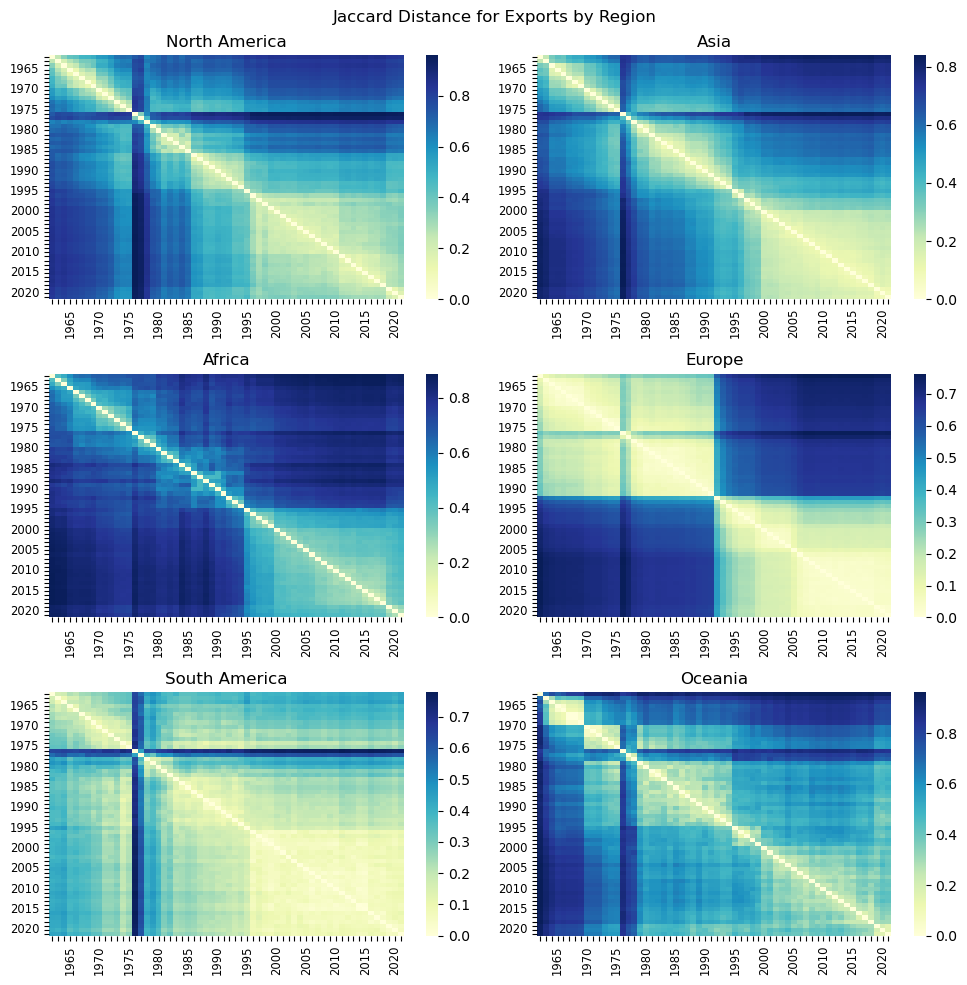

In [37]:
create_heatmaps(jaccard_regions_exports, 'Jaccard Distance for Exports by Region')

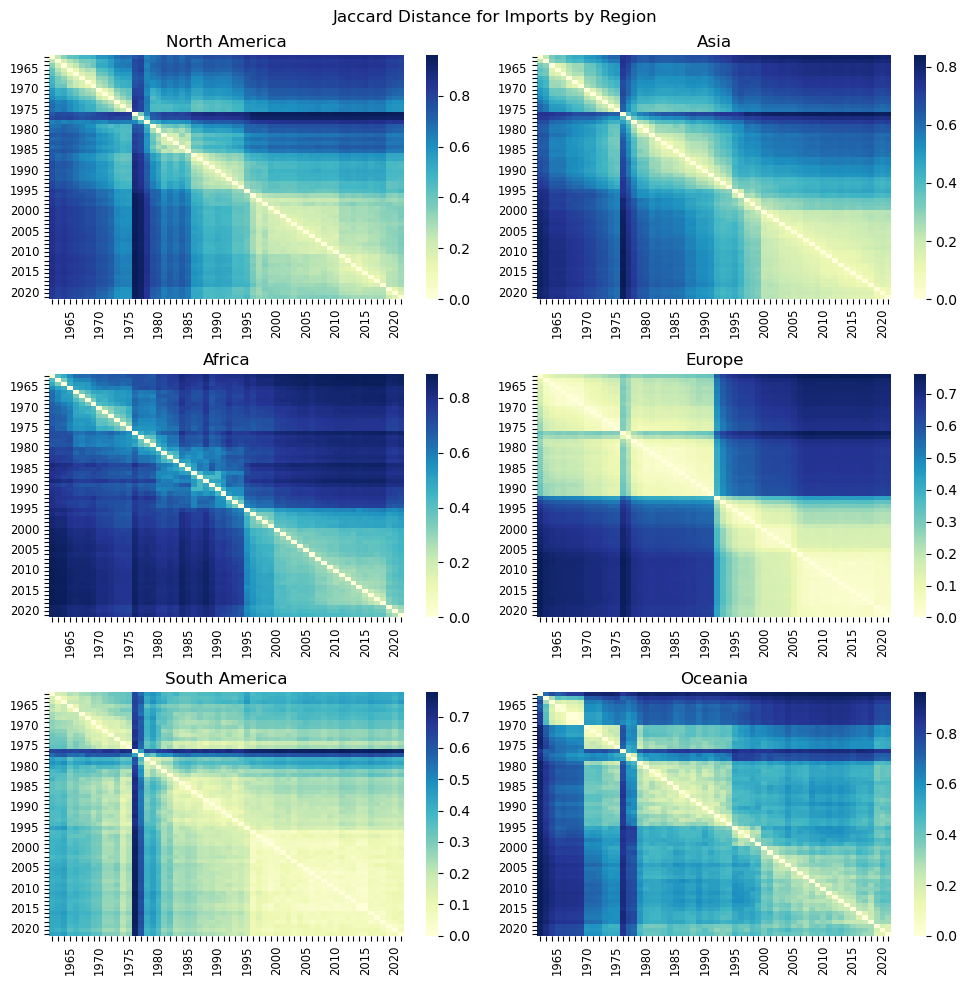

In [61]:
create_heatmaps(jaccard_regions_imports, 'Jaccard Distance for Imports by Region')